# Axes

The axes are referenced to the tool/carriage:

X - moves towards/away from the tool (perpendicular to the carriage).

Y - moves along the carriage axis

Z - Vertical positioning, rarely used.

A - Yaw of the robot. I believe this rotates around the delivery point of the fibre (the tip of the final roller). The rotation is around the Z axis.

B - Rotation around Y axis (I think), rarely used.

C - Rotation around X axis (I think), rarely used.

E1 - Rotation of the payout eye. 

E2 - Not used, related to the tape placement head I believe.

E3 - This rotates both chucks (headstock and tailstock) together, in a synchronised fashion. 

E4 - This rotates the tailstock ONLY. For example, if you wish to only rotate the headstock, you would require equivalent +ve E3 and -ve E4 motion


In [54]:
import pandas, re, operator

fname = "output/cadfil1/4axisnoyaw.src"
ftext = open(fname).read()

headers = [ "Y", "X", "Z", "A", "E1", "E2", "E3", "E4" ]
def lin2series(lin):
    values = [0.0]*len(headers)
    for e in lin.split(","):
        k, v = e.split()
        values[headers.index(k)] = float(v)
    return pandas.Series(values, headers)

reforblk = "(?s)LIN \{(.*?)\}\s*HALT.*?FOR N_CYC=1 to \s*(\d+)\n(.*?)ENDFOR"
forblks = re.findall(reforblk, ftext)

pblks = [ ]
for forblk in forblks:
    lins = re.findall("LIN_REL \{(.*?)\}", forblk[2])
    df = pandas.DataFrame([lin2series(lin)  for lin in lins])
    sumlinrels = sum(map(operator.itemgetter(1), df.iterrows()), start=lin2series("Y 0"))
    pblk = ({ "linstart":lin2series(forblk[0]), "Ncycles":int(forblk[1]), 
              "sumlinrels":sumlinrels, "linrels":df })
    pblks.append(pblk)



In [59]:
for pblk in pblks:
    print("Ncycles ", pblk["Ncycles"])
    print("sumlinrels")
    print(pblk["sumlinrels"])
    print("\n")
    

Ncycles  22
sumlinrels
Y    -8.260059e-14
X     0.000000e+00
Z     0.000000e+00
A     0.000000e+00
E1    1.086364e+04
E2   -2.664535e-15
E3    0.000000e+00
E4    0.000000e+00
dtype: float64


Ncycles  117
sumlinrels
Y     1.527667e-13
X    -1.776357e-14
Z     0.000000e+00
A     0.000000e+00
E1    1.581197e+03
E2    1.776357e-14
E3    0.000000e+00
E4    0.000000e+00
dtype: float64




In [81]:
for pblk in pblks:
    print("Ncycles ", pblk["Ncycles"])
    print("E1rot", pblk["sumlinrels"]["E1"]%360, "total", (pblk["sumlinrels"]["E1"]*pblk["Ncycles"])%360)

    

Ncycles  22
E1rot 63.63600000000042 total 319.99199999999837
Ncycles  117
E1rot 141.1969999999999 total 320.04899999999907


29

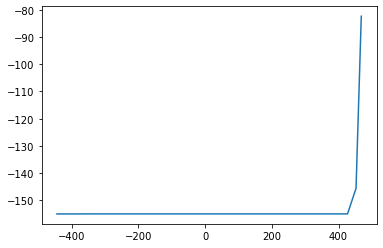

In [84]:
from matplotlib import pyplot as plt
pthcyc1 = pandas.concat((pandas.DataFrame([pblk["linstart"]]), pblk["linrels"])).cumsum()
pc = pthcyc1.iloc[:10]
plt.plot(pc.Y, pc.X)


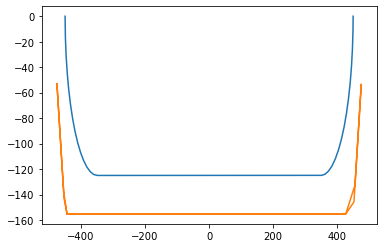

In [90]:
th2file1 = 'output/cadfil1/Vesselv2.TH2'
th2df1 = pandas.read_csv(th2file1, sep="\s+", skipfooter=5, engine='python')
plt.plot(th2df1.X, -th2df1.R)
plt.plot(pthcyc1.Y, pthcyc1.X)


In [ ]:
# Given an XY position for the tape layer, draw the horizon line on 
# the mandrel the tape will be landing.  
# Can this be solved for a radially symetric shape as above?
# It can be done easily on a mesh by cycling through the edges